### 在多分类任务中，模型最终输出的是logits

In [1]:
# logits
import numpy as np
logits = [3.2, 1.5, -0.9]
# 我们可以使用softmax将logtis转化为概率（和为1）
def softmax(logits):
    exp = np.exp(logits)
    return exp / np.sum(exp)

probs = softmax(logits)
print(f'Softmax output: {probs}')
print(f'Sum of probs: {np.sum(probs)}')

Softmax output: [0.83385018 0.15233069 0.01381913]
Sum of probs: 1.0


### 常见错误：CrossEntropyLoss不需要加Softmax！！！

In [2]:
# 错误写法
# import torch
# import torch.nn as nn
# logits = [3.2, 1.5, -0.9]
# probs = torch.softmax(logits)
# loss = nn.CrossEntropyLoss(probs, targets)

# 正确写法
# logits = [3.2, 1.5, -0.9]
# criterion = nn.CrossEntropyLoss()
# loss = nn.CrossEntropyLoss(logits, targets)

### CrossEntropy的机制重点
- CrossEntropyLoss = log(softmax(logits)) -- 使用的是Log_Softmax，为了防止数据溢出

In [3]:
import torch
import torch.nn
import torch.nn.functional as F

logits = torch.tensor([[3.2, 1.5, -0.9]], dtype=torch.float32)
log_softmax = F.log_softmax(logits, dim=1)
print(f'Log-Softmax: {log_softmax}')
print(f'Sum of exp(log_soft_max) is : {torch.exp(log_softmax).sum()}')

Log-Softmax: tensor([[-0.1817, -1.8817, -4.2817]])
Sum of exp(log_soft_max) is : 1.0


### 用Numpy手写softmax + NLLLoss
- CrossEntropyLoss背后逻辑
    - 我们给PyTorch一个模型输出的logits和一个target label
    - 我们首先对每个样本做softmax
    - 然后对应类别上取Negative Log Likelihood，最小化NLL就是最大化似然

In [4]:
import numpy as np

logits = np.array([
[3.2, 1.5, -0.9],
[0.1, 2.3, 1.0]])

targets =  np.array([0, 2])

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

probs = softmax(logits)

log_probs = -np.log(probs[range(len(targets)), targets])
loss = np.mean(log_probs)

print("Softmax probabilities:\n", probs)
print("Negative log-likelihoods:", log_probs)
print("Mean NLL Loss:", loss)


Softmax probabilities:
 [[0.83385018 0.15233069 0.01381913]
 [0.08009858 0.72289072 0.1970107 ]]
Negative log-likelihoods: [0.18170153 1.62449722]
Mean NLL Loss: 0.9030993730437878


### 可视化

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 创建logits和真实标签
logits = np.array([
    [3.2, 1.5, -0.9],
    [0.1, 2.3, 1.0]
])
targets = np.array([0,2])

# 数值稳定的softmax -- 使用logsumexp trick
stable_logits = logits - np.max(logits, axis=1, keepdims=True)
exp = np.exp(logits)
probs = exp/np.sum(exp, axis=1, keepdims=True) # exp.shape = (2,3)，np.sum(..., axis=1, keepsdim=True)后变为(2,1), axis=x的维度变为1，另一个维度保持

# 求每个样本对应target的Negative Log Likelihood Loss
target_nllLoss = -np.log(probs[range(len(targets)), targets])
average_loss = np.mean(target_nllLoss)

# DataFrame
df = pd.DataFrame({
    'Sample Id': np.arange(len(targets)),
    'target': targets,
    'logit_0': logits[:, 0],
    'logit_1': logits[:, 1], 
    'logit_2': logits[:, 2],
    'prob_0': probs[:, 0],
    'prob_1': probs[:, 1],
    'prob_2': probs[:, 2],
    'target_nllLoss': target_nllLoss
})

print('\n=== Softmax + NLLLoss 每步输出')
print(df.to_string(index=False))
print(f'Average Loss: {average_loss:4f}')


=== Softmax + NLLLoss 每步输出
 Sample Id  target  logit_0  logit_1  logit_2   prob_0   prob_1   prob_2  target_nllLoss
         0       0      3.2      1.5     -0.9 0.833850 0.152331 0.013819        0.181702
         1       2      0.1      2.3      1.0 0.080099 0.722891 0.197011        1.624497
Average Loss: 0.903099


### 验证实验：PyTorch CrossEntropyLoss和手写的numpy softmax + NLLLoss

In [6]:
import numpy as np
import torch
import torch.nn as nn

# logits.shape = (2,3)
logits = np.array([
    [3.2, 1.5, -0.9],
    [0.1, 2.3, 1.0]
])
targets = [0,2] # 表示第一个样本是类别0，第二个样本是类别2

# softmax的实现
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x/np.sum(e_x, axis=1, keepdims=True)

probs = softmax(logits)
nll_loss = -np.log(probs[np.arange(len(targets)), targets])
average_loss = np.mean(nll_loss)
average_loss1 = np.sum(nll_loss) / len(nll_loss)
print(f'手动实现的loss为: {average_loss}')
# 
# 用nn.CrossEntropyLoss来实现
import torch.nn as nn
logits_torch = torch.tensor(logits, dtype=torch.float32)
targets_torch = torch.tensor(targets, dtype=torch.long)

criterion = nn.CrossEntropyLoss()
loss_torch = criterion(logits_torch, targets_torch)
print(f'torch.nn CrossEntropy算出来的loss是: {loss_torch}')



手动实现的loss为: 0.9030993730437878
torch.nn CrossEntropy算出来的loss是: 0.9030993580818176


### 来实现一个三分类+CrossEntropy的小实战

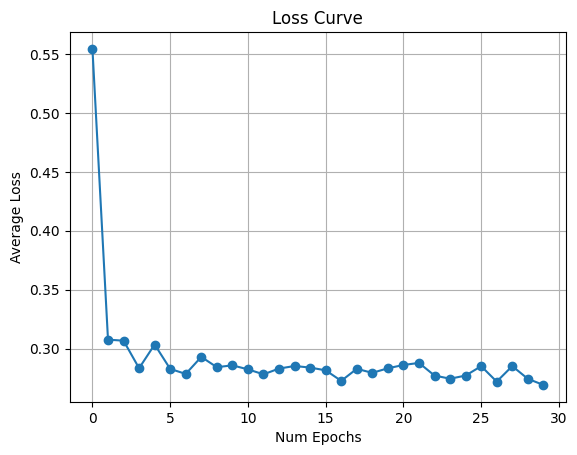

Trained Model's accuracy is: 89.2593%


In [7]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

'''---数据集---'''

# 生成数据集
num_samples_per_class = 300
class0 = torch.randn(num_samples_per_class, 2) + torch.tensor([-2.0,0.0])
class1 = torch.randn(num_samples_per_class, 2) + torch.tensor([2.0, 0.0])
class2 = torch.randn(num_samples_per_class, 2) + torch.tensor([0.0, 2.0])

X = torch.cat([class0, class1, class2], dim=0)
y = torch.cat([torch.zeros(num_samples_per_class),
               torch.ones(num_samples_per_class),
               torch.full((num_samples_per_class,), 2)
               ]).long() # 因为CrossEntropyLoss只接受torch.int64的label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# # 打乱顺序
# index = torch.randperm(len(X))
# X = X[index]
# y = y[index]

# dataset = TensorDataset(X, y)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)


'''---创建模型---'''
class MultiLayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )
    def forward(self, X):
        return self.net(X)
    
model = MultiLayerPerceptron()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, num_epochs, criterion, train_dataloader):
    model.train()
    loss_history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_x, batch_y in train_dataloader:
            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_x.size(0)
        average_loss = epoch_loss / len(train_dataloader.dataset)
        loss_history.append(average_loss)
    return loss_history

def plot_loss_curve(loss_history):
    plt.plot(loss_history, marker='o')
    plt.xlabel('Num Epochs')
    plt.ylabel('Average Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()

def evaluate_model(model, test_dataloader):
    model.eval()
    num_correct = 0
    num_total = 0
    with torch.inference_mode():
        for batch_x, batch_y in test_dataloader:
            logits = model(batch_x)
            prediction = torch.argmax(logits, dim=1)
            num_correct += (prediction == batch_y).sum().item()
            num_total += batch_y.size(0)
    accuracy = num_correct/num_total
    print(f"Trained Model's accuracy is: {accuracy * 100:.4f}%")

loss_history = train_model(model=model, num_epochs=30, criterion=criterion, train_dataloader=train_dataloader)
plot_loss_curve(loss_history)

# 查看训练后模型的正确率
evaluate_model(model, test_dataloader=test_dataloader)


### 画出Decision Boundary

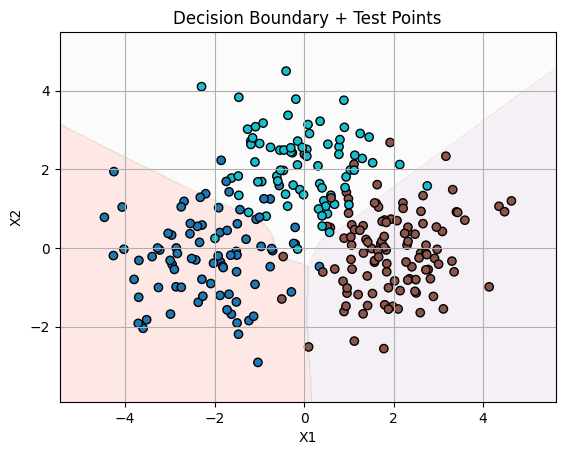

In [8]:
# plot decision boundary
def plot_decision_boundary(model, X, y):
    model.eval()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02
    xx, yy = torch.meshgrid(
        torch.arange(x_min, x_max, h),
        torch.arange(y_min, y_max, h),
        indexing='ij'
    )
    grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)

    with torch.inference_mode():
        logits = model(grid)
        preds = torch.argmax(logits, dim=1).reshape(xx.shape)
    plt.contourf(xx, yy, preds, alpha=0.3, cmap='Pastel1')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', edgecolors='k')
    plt.title("Decision Boundary + Test Points")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.grid(True)
    plt.show()
plot_decision_boundary(model=model, X=X_test, y=y_test)

### Confusion Matrix + AUCROC + Precision_Recall Curve

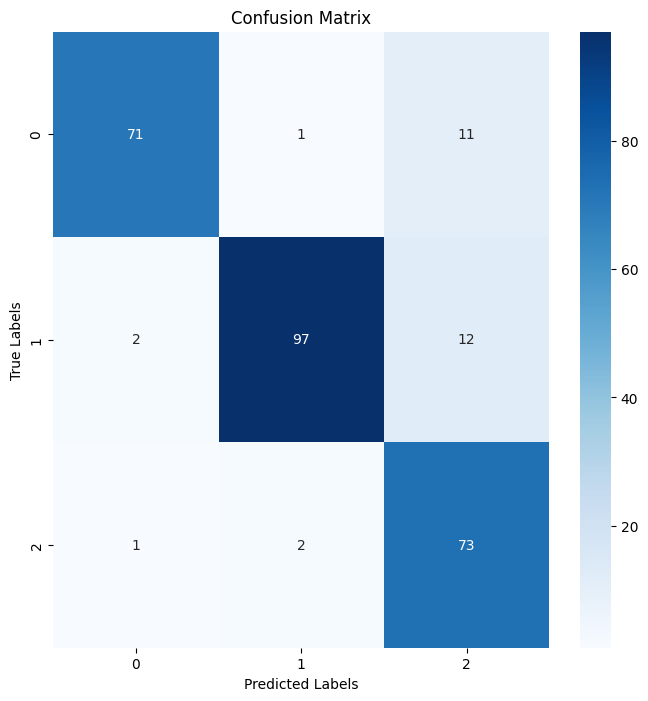

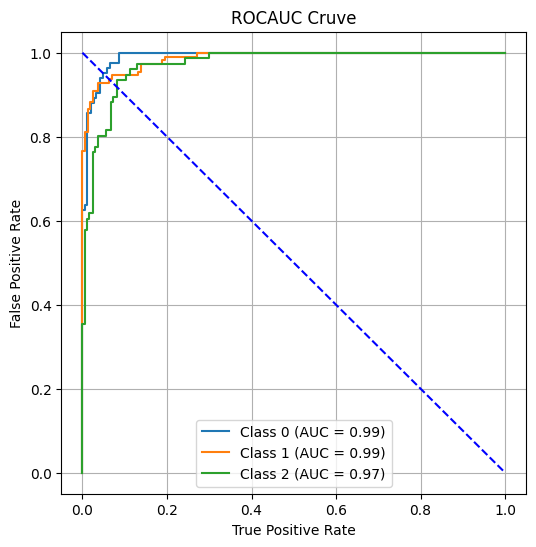

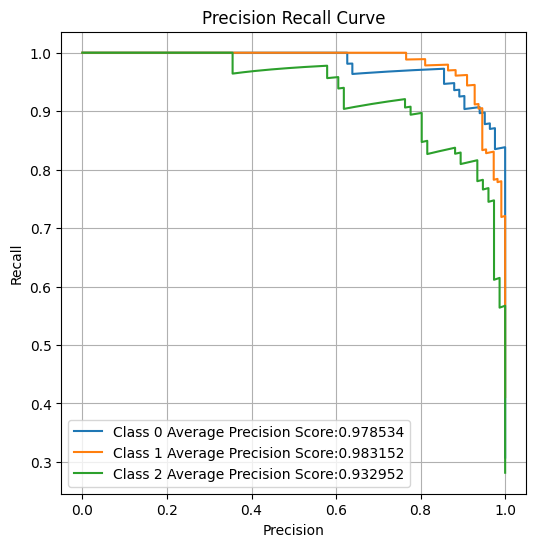

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import torch

'''---Confusion Matrix---'''
def draw_confusion_matrix(model, X_test, y_test):
    model.eval()
    with torch.inference_mode():
        logits = model(X_test)
        y_pred = torch.argmax(logits, dim=1).squeeze()
    cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
draw_confusion_matrix(model=model, X_test=X_test, y_test=y_test)

'''---ROC-AUC---'''
def draw_aucroc_curve(model, X_test, y_test): 
    num_classes = len(np.unique(y_test)) # 获取num_classes
    # 因为roc_curve本来只适应于二元分类，所以为了给多分类绘图，我们把true labels转化为one-hot形式[[1,0,0],[0,1,0],......]
    # OneHotEncoder必须接受二维的输入，y_test一般是一维的(num_samples，)
    # 原来的y_test是[1,2,1,0,1]这样的，reshape后就变成
    # y.reshape(-1, 1) = [[1],
                        # [2],
                        # [1],
                        # [0],
                        # [1]]
    #这样的形状
    # OneHotEncoder之后变成:
    # [[0,1,0],
    #  [0,0,1],
    #  [0,1,0],
    #  [1,0,0],
    #  [0,1,0]]
    encoder = OneHotEncoder(sparse_output=False)
    y_test_oh = encoder.fit_transform(y_test.reshape(-1, 1)) # [num_samples, num_classes]
    probs = torch.softmax(model(X_test), dim=1).detach().numpy()
    fpr, tpr, roc_auc_scores = dict(), dict(), dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], probs[:, i])
        roc_auc_scores[i] = roc_auc_score(y_test_oh[:, i], probs[:, i])
    plt.figure(figsize=(6, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_scores[i]:.2f})')
    plt.plot([0, 1], [1, 0], color='blue', linestyle='--')
    plt.xlabel('True Positive Rate')
    plt.ylabel('False Positive Rate')
    plt.title('ROCAUC Cruve')
    plt.legend()
    plt.grid(True)
    plt.show()

draw_aucroc_curve(model=model, X_test=X_test, y_test=y_test)


'''---Precision Recall Curve'''
def draw_pr_curve(model, X_test, y_test):
    # 和ROC curve类似，PR曲线原本也只适用于二元分类
    # 所以我们需要OneHotEncode True label，然后再One vs Rest画图
    num_classes = len(np.unique(y_test))
    encoder = OneHotEncoder(sparse_output=False)
    y_test_oh = encoder.fit_transform(y_test.reshape(-1,1))
    probs = torch.softmax(model(X_test), dim=1).detach().numpy()
    precision, recall, aavg_prec = dict(), dict(), dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_oh[:, i], probs[:, i])
        aavg_prec[i] = average_precision_score(y_test_oh[:, i], probs[:, i])
    plt.figure(figsize=(6, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], label=f'Class {i} Average Precision Score:{aavg_prec[i]:2f}')
    # plt.plot([0,1],[0,1], color='blue', linestyle='--')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

draw_pr_curve(model=model, X_test=X_test, y_test=y_test)
# PR 曲线为什么没画到头：recall 没到 0
# 我们把模型输出的“是猫的概率”从 高到低当成阈值，一个个试过去：
# 概率 > 0.9 → 我就认定是猫
# 概率 > 0.8 → 我也认定是猫
# ……一直降到概率 > 0.01
# 每降一次，就重新计算一次 precision / recall，拼成一条曲线。
# 那问题来了：
# 如果模型从来没把任何图片预测得非常不像猫（比如最低也预测 0.3），
# 那么就**没有足够“低的概率阈值”**去把所有图片都当猫，从而：
# Recall 就永远达不到 0，PR 曲线也就没办法画到最右下角
    
